✅ Traditional face recognition model loaded successfully.


Testing Masked Faces (Baseline Model): 100%|██████████| 19/19 [00:02<00:00,  9.01it/s]



==== Traditional Model on Masked Faces ====
Final Accuracy: 5.26%
              precision    recall  f1-score   support

   alexandra      0.000     0.000     0.000         5
    courtney      0.000     0.000     0.000         3
   elizabeth      0.250     0.200     0.222         5
       henry      0.000     0.000     0.000         3
         zac      0.000     0.000     0.000         3

    accuracy                          0.053        19
   macro avg      0.050     0.040     0.044        19
weighted avg      0.066     0.053     0.058        19



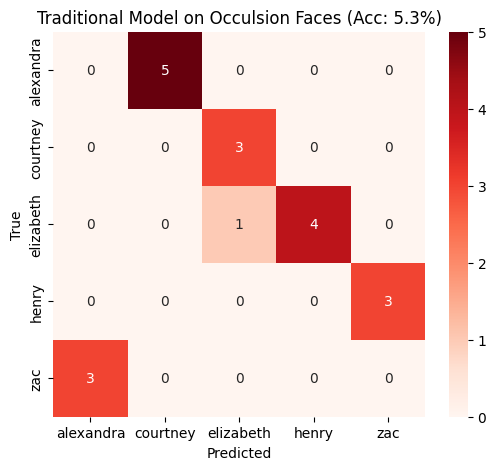

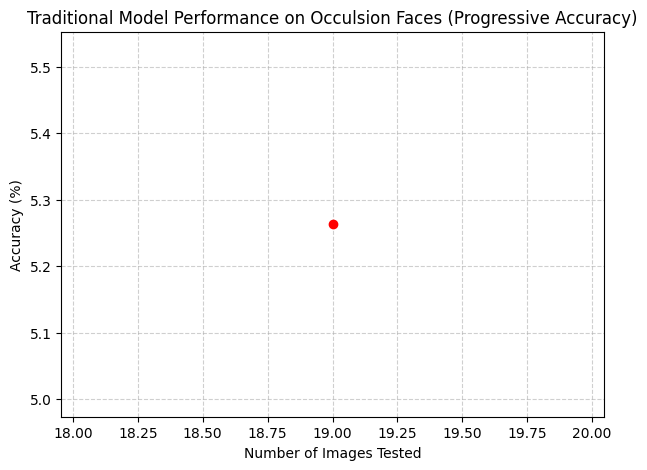

Evaluating Performance Trend: 100%|██████████| 19/19 [00:02<00:00,  8.51it/s]


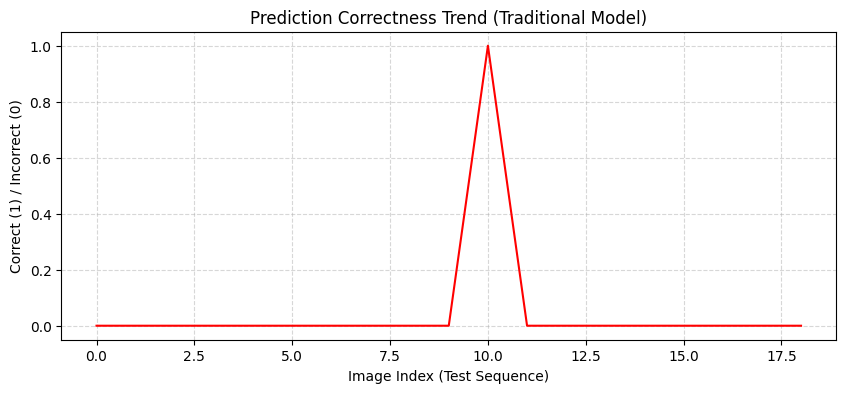

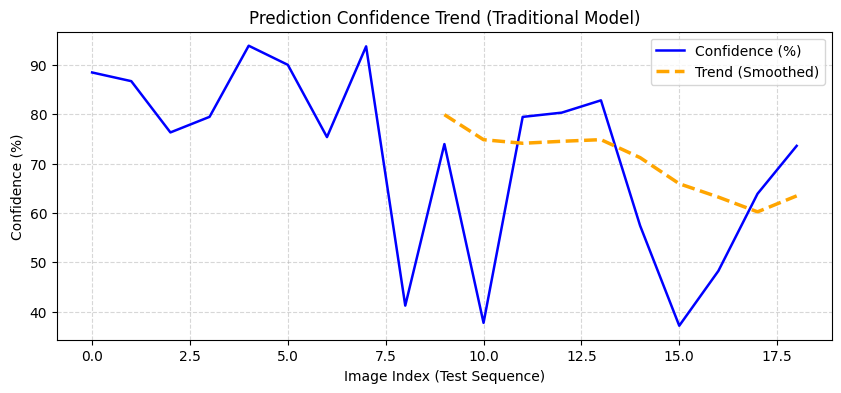

✅ Total Samples: 19
Average Confidence: 71.56%
Accuracy: 5.26%


In [11]:
# ============================================================
# 🎭 TESTING MASKED FACES ON TRADITIONAL FACE RECOGNITION MODEL
# With real-time accuracy trend visualization
# ============================================================

!pip install seaborn --quiet

import os, torch, cv2, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_DIR = "/content/drive/MyDrive/FaceQuadrantNet"
MASK_DIR = f"{BASE_DIR}/Dataset_masked"
MODEL_PATH = f"{BASE_DIR}/baseline_face_recognition.pth"

TARGET_CLASSES = ["alexandra", "courtney", "elizabeth", "henry", "zac"]

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# ---------------- LOAD TRADITIONAL MODEL ----------------
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(TARGET_CLASSES))

ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model = model.to(DEVICE)
model.eval()
print("✅ Traditional face recognition model loaded successfully.")

# ---------------- DATASET LOADER ----------------
class SimpleFaceDataset(Dataset):
    def __init__(self, root, classes, transform):
        self.samples = []
        self.transform = transform
        self.classes = [c.lower() for c in classes]
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        for cls in self.classes:
            folder = Path(root)/cls
            if not folder.exists(): continue
            for p in folder.glob("*"):
                if p.suffix.lower() in [".jpg",".jpeg",".png"]:
                    self.samples.append((str(p), self.class_to_idx[cls]))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        img_t = self.transform(img)
        return img_t, label, path

# ---------------- TESTING WITH ACCURACY TREND ----------------
def evaluate_baseline(model, dataset_path, classes, step=50):
    ds = SimpleFaceDataset(dataset_path, classes, val_tfms)
    loader = DataLoader(ds, batch_size=1, shuffle=False)
    all_preds, all_labels = [], []
    accuracy_trend, steps = [], []

    with torch.no_grad():
        for i, (img, label, path) in enumerate(tqdm(loader, desc="Testing Masked Faces (Baseline Model)")):
            img, label = img.to(DEVICE), label.to(DEVICE)
            out = model(img)
            preds = torch.argmax(out, dim=1)
            all_preds.append(preds.item())
            all_labels.append(label.item())

            # Record running accuracy every "step" images
            if (i+1) % step == 0 or (i+1) == len(loader):
                acc = accuracy_score(all_labels, all_preds)
                accuracy_trend.append(acc)
                steps.append(i+1)

    # Final metrics
    final_acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=classes, digits=3)

    return final_acc, cm, report, steps, accuracy_trend

# ---------------- RUN TESTING ----------------
acc, cm, report, steps, acc_trend = evaluate_baseline(model, MASK_DIR, TARGET_CLASSES)

print(f"\n==== Traditional Model on Masked Faces ====")
print(f"Final Accuracy: {acc*100:.2f}%")
print(report)

# ---------------- VISUALIZE CONFUSION MATRIX ----------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=TARGET_CLASSES, yticklabels=TARGET_CLASSES)
plt.title(f"Traditional Model on Occulsion Faces (Acc: {acc*100:.1f}%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---------------- VISUALIZE ACCURACY TREND ----------------
plt.figure(figsize=(7,5))
plt.plot(steps, [a*100 for a in acc_trend], marker='o', color='red', linewidth=2.5)
plt.title("Traditional Model Performance on Occulsion Faces (Progressive Accuracy)")
plt.xlabel("Number of Images Tested")
plt.ylabel("Accuracy (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()




#....................

# ---------------- VISUALIZE PREDICTION PERFORMANCE TREND ----------------
import torch.nn.functional as F

# Get prediction correctness (1 for correct, 0 for wrong) and confidences
pred_correctness = []
pred_confidence = []

ds = SimpleFaceDataset(MASK_DIR, TARGET_CLASSES, val_tfms)
loader = DataLoader(ds, batch_size=1, shuffle=False)

with torch.no_grad():
    for img, label, path in tqdm(loader, desc="Evaluating Performance Trend"):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        out = model(img)
        probs = F.softmax(out, dim=1)
        conf, pred = torch.max(probs, 1)
        correct = (pred == label).item()
        pred_correctness.append(correct)
        pred_confidence.append(conf.item())

# ---------------- GRAPH 1: Correctness Fluctuation ----------------
plt.figure(figsize=(10,4))
plt.plot(range(len(pred_correctness)), pred_correctness, color='red', linewidth=1.5)
plt.title("Prediction Correctness Trend (Traditional Model)")
plt.xlabel("Image Index (Test Sequence)")
plt.ylabel("Correct (1) / Incorrect (0)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ---------------- GRAPH 2: Confidence Fluctuation ----------------
plt.figure(figsize=(10,4))
plt.plot(range(len(pred_confidence)), np.array(pred_confidence)*100, color='blue', linewidth=1.8, label='Confidence (%)')

# Rolling average (trendline)
if len(pred_confidence) > 10:
    window = 10
    rolling_avg = np.convolve(pred_confidence, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(rolling_avg)+window-1), np.array(rolling_avg)*100,
             color='orange', linestyle='--', linewidth=2.5, label='Trend (Smoothed)')

plt.title("Prediction Confidence Trend (Traditional Model)")
plt.xlabel("Image Index (Test Sequence)")
plt.ylabel("Confidence (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Optional: print summary stats
print(f"✅ Total Samples: {len(pred_confidence)}")
print(f"Average Confidence: {np.mean(pred_confidence)*100:.2f}%")
print(f"Accuracy: {np.mean(pred_correctness)*100:.2f}%")


